## ============ SVMs (Binary Image Classification) ==============

#### SVM Read Link: https://www.cse.iitd.ac.in/~parags/teaching/2023/col774/supp_material/svm.pdf

#### Intel Image Classification Dataset
#### Classes: Class 0 (City Image)    and     Class 1 (Forest Image)

### [Direct Solution and CVXOPT Python]
##### Install Link: https://cvxopt.org/install/index.html

### HyperParameters

In [1]:
#####################################    HYPERPARAMETERS    #####################
resize_dim            = 16
use_normalization     = 1
error_factor_C        = 1     # penalty of defying >= 1 constraint
use_l1_regularization = 1     # 1-Xi permitted for each sample; if 0, then Xi = 0


#####################################    ACCURACY DATA    #######################
# error_factor_C = 1
# resize_dim = 16         accuracy (train, valid):   0.90  0.845
# resize_dim = 32         accuracy (train, valid):   0.95  0.807

# error_factor_C = 5
# resize_dim = 16         accuracy (train, valid):   0.91  0.845

# error_factor_C = 0.1
# resize_dim = 16         accuracy (train, valid):   0.89  0.845

# error_factor_C = 0
# resize_dim = 16         accuracy (train, valid):   0.5  0.5

# use_l1_regularization = 0        # how QP gave a feaible solution here?
# resize_dim = 16         accuracy (train, valid):   0.73  0.68

flatten_dim       = resize_dim*resize_dim*3 

### Testing Data Before and After Resizing

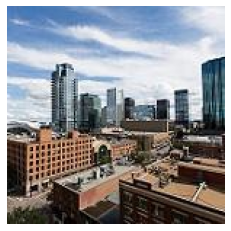

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread('dataset_image/train/0/10006.jpg')
plt.axis('off')  # Turn off the axis
imgplot = plt.imshow(img)

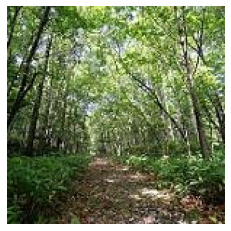

In [3]:
img=mpimg.imread('dataset_image/train/1/10010.jpg')
plt.axis('off')  # Turn off the axis
imgplot = plt.imshow(img)

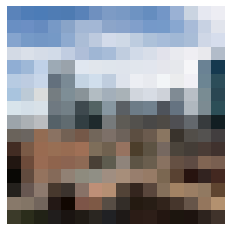

In [4]:
from PIL import Image
img = Image.open("dataset_image/train/0/10006.jpg")
resized_img = img.resize((resize_dim, resize_dim), Image.Resampling.LANCZOS)    # take average of rgb in neighborhood
plt.axis('off')  # Turn off the axis
imgplot = plt.imshow(resized_img)

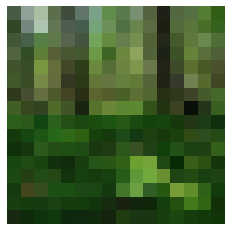

In [5]:
img = Image.open("dataset_image/train/1/14621.jpg")
resized_img = img.resize((resize_dim, resize_dim), Image.Resampling.LANCZOS)    # take average of rgb in neighborhood
plt.axis('off')  # Turn off the axis
imgplot = plt.imshow(resized_img)

### Flatten and Unflatten Array

In [6]:
import numpy as np                
np_array = np.asarray(resized_img, dtype="int32")
#print (np_array)
flat_array = np_array.flatten()
#print (flat_array)

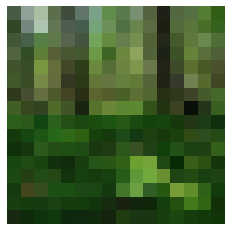

In [7]:
unflat_array = np.reshape(np.uint32(flat_array), (resize_dim, resize_dim, 3))
plt.axis('off')  # Turn off the axis
imgplot = plt.imshow(unflat_array)

### Loading and Normalizing Training Data: (Class 0 and 1)

In [8]:
import os

def load_image(infilename):
    img = Image.open(infilename)
    img.load()
    resized_img = img.resize((resize_dim, resize_dim), Image.Resampling.LANCZOS)    # take average of rgb in neighborhood
    np_array    = np.asarray(resized_img, dtype="int32")
    flat_array  = np_array.flatten()
    return flat_array

x_train_0 = np.empty([0, resize_dim*resize_dim*3], dtype="int32")
for filename in os.listdir("dataset_image/train/0/"):
    if filename.endswith(".jpg"): 
        #print (filename)
        filepath   = os.path.join("dataset_image/train/0/", filename)
        newrow     = load_image(filepath)
        x_train_0  = np.vstack([x_train_0, newrow])

x_train_1 = np.empty([0, resize_dim*resize_dim*3], dtype="int32")
for filename in os.listdir("dataset_image/train/1/"):
    if filename.endswith(".jpg"): 
        #print (filename)
        filepath  = os.path.join("dataset_image/train/1/", filename)
        newrow    = load_image(filepath)
        x_train_1  = np.vstack([x_train_1, newrow])

x_valid_0 = np.empty([0, resize_dim*resize_dim*3], dtype="int32")
for filename in os.listdir("dataset_image/val/0/"):
    if filename.endswith(".jpg"): 
        #print (filename)
        filepath   = os.path.join("dataset_image/val/0/", filename)
        newrow     = load_image(filepath)
        x_valid_0  = np.vstack([x_valid_0, newrow])

x_valid_1 = np.empty([0, resize_dim*resize_dim*3], dtype="int32")
for filename in os.listdir("dataset_image/val/1/"):
    if filename.endswith(".jpg"): 
        #print (filename)
        filepath  = os.path.join("dataset_image/val/1/", filename)
        newrow    = load_image(filepath)
        x_valid_1  = np.vstack([x_valid_1, newrow])

In [9]:
print ("number of class 0 training   samples: ", len(x_train_0))
print ("number of class 1 training   samples: ", len(x_train_1))
print ("number of class 0 validation samples: ", len(x_valid_0))
print ("number of class 1 validation samples: ", len(x_valid_1))
#print (x_train_1[1])

number of class 0 training   samples:  2380
number of class 1 training   samples:  2380
number of class 0 validation samples:  200
number of class 1 validation samples:  200


In [10]:
if use_normalization == 1:
    x_train_0 = x_train_0/255
    x_train_1 = x_train_1/255
    x_valid_0 = x_valid_0/255
    x_valid_1 = x_valid_1/255
#print (x_train_1[1])

### QP Solver

##### Example: https://cvxopt.org/examples/tutorial/qp.html
##### IMP POINT: considers the list of lists as column major

In [ ]:
from cvxopt import matrix, solvers

num_training_samples = len(x_train_0) + len(x_train_1)    # number of error_i
dim                  = flatten_dim                        # number of wi's
num_var              = num_training_samples + dim + 1     # includes intercept/bias b

#####################   Defining Objective function   ####################
P_mat = []
q_vec = [0.0]*num_var
for index in range(0, num_var):
    temp_list = [0.0]*num_var
    if   (index < dim):             # index = dim corresponds to variable b (intercept)
        temp_list[index] = 1.0 
    elif (index > dim):
        q_vec[index]     = error_factor_C
    P_mat.append(temp_list)
    

#####################   Defining Constrainst   ####################
G_mat = []
h_vec = [-1.0]*num_training_samples
index = 0
for row in x_train_0:
    row_list          = row.tolist()
    temp_list         = [-1.0*i for i in row_list]    # multiply by class label
    temp_list.append(-1)                              # for variable b
    error_list        = [0]*num_training_samples
    error_list[index] = 1*use_l1_regularization
    temp_list        += error_list
    neg_temp_list     = [-1.0*i for i in temp_list]   # convert to less than constraint
    G_mat.append(neg_temp_list)
    index += 1

for row in x_train_1:
    row_list          = row.tolist()
    temp_list         = [1.0*i for i in row_list]    # multiply by class label
    temp_list.append(1)                              # for variable b
    error_list        = [0]*num_training_samples
    error_list[index] = 1*use_l1_regularization
    temp_list        += error_list
    neg_temp_list     = [-1.0*i for i in temp_list]  # convert to less than constraint
    G_mat.append(neg_temp_list)
    index += 1

h_vec_0 = [0.0]*num_training_samples
h_vec  += h_vec_0
for index in range(0, num_training_samples):
    temp_list                  = [0.0]*num_var
    temp_list[dim + index + 1] = -1.0
    G_mat.append(temp_list)

assert (2*num_training_samples == len(G_mat))
assert (2*num_training_samples == len(h_vec))
index = 0
for item in G_mat: 
    assert len(item) == num_var, ("failed at index: ", index, len(item)) 
    index += 1

###############################  Invoding QP Solver  ###########
P = 2*matrix(np.array(P_mat))   # considers as row major
q = matrix(q_vec)
G = matrix(np.array(G_mat))     # considers as row major
h = matrix(h_vec)
sol=solvers.qp(P, q, G, h)

print ("SOLVED!")

solution_array = (np.array(sol['x']).flatten())[:dim+1]
#print ("Solution       : ", solution_array)
print ("Solution Length: ", len(solution_array))

     pcost       dcost       gap    pres   dres
 0: -2.8962e+03  1.4617e+04  9e+04  5e+00  4e+02
 1:  7.7445e+03 -7.1644e+03  2e+04  8e-01  7e+01
 2:  4.4577e+03 -1.1992e+03  7e+03  2e-01  2e+01


In [ ]:
# QP Problem Format: CVXOPT solves problems of the form:
# Minimize: 1/2*x^T.P.x+q^T.x

# subject to:
#             Gx≤h and Ax=b

# where:

#     P is a positive semidefinite matrix (defining the quadratic term),
#     q, G, h, A, and b are vectors or matrices defining linear constraints.

# sol=solvers.qp(Q, p, G, h, A, b)

In [ ]:
# min   (a^2 + b^2 + . . . )  +   error_i*C

# s.t.  class_label(ax1 + by1 + . . . + z) >= 1 - error_i   for all xi's and yi's . . .
#       error_i >= 0

In [ ]:
def pred(matrix):
    pred_ary  = np.empty(len(matrix), dtype="int32")
    distance  = matrix.dot(solution_array[:dim]) + solution_array[dim]           # wTx+ b. for each x
    for index in range(0, len(distance)):
        val = distance[index]
        if val >= 0:
            pred_ary[index] = 1
        else:
            pred_ary[index] = -1
    return pred_ary

### Train and Validation Prediction

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
classes = [-1,1]

y_train_true  = [-1]*len(x_train_0) + [1]*len(x_train_1) 
y_train_pred  = pred(np.concatenate((x_train_0, x_train_1), axis=0))
print("PR Report         : \n", classification_report(y_train_true, y_train_pred, labels=classes, zero_division=0))
print("Confusion Matrix  : \n", confusion_matrix(y_train_true, y_train_pred))
print("\nTraining Accuracy        : ", accuracy_score(y_train_true, y_train_pred), "\n")

y_valid_true  = [-1]*len(x_valid_0) + [1]*len(x_valid_1) 
y_valid_pred  = pred(np.concatenate((x_valid_0, x_valid_1), axis=0))
print("PR Report         : \n", classification_report(y_valid_true, y_valid_pred, labels=classes, zero_division=0))
print("Confusion Matrix  : \n", confusion_matrix(y_valid_true, y_valid_pred))
print("\nValidation Accuracy        : ", accuracy_score(y_valid_true, y_valid_pred), "\n")